In [14]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import datetime
from scipy import stats
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 14
fig_size[1] = 10

This notebook's main utility is to provide (imperfect) evidence of the historical economic challenges faced by independent stakers and the observable impact on the # node population. 

First we retrieve relevant dispatcher events using Dune. Check out the SQL queries here: 
- Worker **Commitments** https://dune.xyz/queries/48938
This pulls, on each period, each (staker) address – whose correspondng worker successfully committed to the next period. 
- Staker **Locks** https://dune.xyz/queries/54332
This pulls, on each period, any token locking event by a staker and the sum of tokens locked.
- Staker **Withdrawals** https://dune.xyz/queries/54339
This pulls, on each period, any token withdrawal event by a staker and the sum of tokens withdrawn. 

Note that the Locks and Withdrawals tables do not include preallocated holdings or the growth in stakes due to restaking, and so underestimate the total capital staked at a given period – hence this notebook is WIP. For now, this study provides some insight into the variance of committed capital period-to-period, how this impacts the fluctuations of the break-even stake size, and how this in turn affects the population of nodes (addresses) and their respective solvencies. 

In [15]:
df_c = pd.read_csv(r'commitments.csv')
df_l = pd.read_csv(r'locks.csv')
df_w = pd.read_csv(r'withdrawals.csv')
df_c['timestamp'] = pd.to_datetime(df_c['timestamp']) #standardize the date format
df_l['timestamp'] = pd.to_datetime(df_l['timestamp'])
df_w['timestamp'] = pd.to_datetime(df_w['timestamp'])
df_c['timestamp'] = df_c['timestamp'].dt.date
df_l['timestamp'] = df_l['timestamp'].dt.date
df_w['timestamp'] = df_w['timestamp'].dt.date

In [16]:
# Join the three tables into one 
df_temp = pd.merge(df_c, df_l, how='left', on=['Staker', 'timestamp']) 
df_merged = pd.merge(df_temp, df_w, how='left', on=['Staker', 'timestamp'])
df_merged.fillna(0, inplace=True)

In [55]:
#We focus on node behavior up until the period duration extension on April 14th 2021 (i.e. the era when periods were 1 day long)
split_date = pd.to_datetime('2021-04-15')
df_1day = df_merged.loc[(df_merged['timestamp'] < split_date)]
df_7day = df_merged.loc[(df_merged['timestamp'] >= split_date)]
df_1day = df_1day.reset_index(drop=True)

/Users/arjun/opt/miniconda3/envs/myenv/lib/python3.9/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


In [56]:
#We calculate a rudimentary value for each stake value on every period that the associated worker commits. 
df_1day = df_1day.groupby(['timestamp','Staker']).sum().groupby(level='Staker').cumsum()
df_1day['Staked'] = df_1day['Locked'].copy() - df_1day['Withdrawn'].copy()
df_1day

period      Locked  \
timestamp  Staker                                                           
2020-10-15 \x000000b424ca716ba3b1095321216aae2ac412e0       1      0.0000   
           \x000001dc0668cf89e9bab6daaa01822132c9829b       1      0.0000   
           \x0000032ccc3f5e494a30a354f2ca8649b5246965       1      0.0000   
           \x000003379cc5026a3b3b9dd13a733dbbf1278d05       1      0.0000   
           \x000003c63bfe00c235d3233b3de02a2bb8bfe9ed       1      0.0000   
...                                                       ...         ...   
2021-04-14 \xff2fed9cb48196ec35fd97b290c583e7a63b17b7    5317  15000.0000   
           \xff86557af05b3e67401edd572cff884709085ccc    5845  77644.6853   
           \xff8a662fab0745a5032ccf326fd14b235fa88c2b    7060  15000.0000   
           \xffa7fa47a24c49c03bb97fc253daa621b6c94d13     183  15000.0000   
           \xffc8995f71f903f42c27081ab2f644db730dc543    5428  15000.0000   

                                                        Withdrawn   Staked  
timestamp  Staker                                                           
2020-10-15 \x000000b424ca716ba3b1095321216aae2ac412e0      0.0000      0.0  
           \x000001dc0668cf89e9bab6daaa01822132c9829b      0.0000      0.0  
           \x0000032ccc3f5e494a30a354f2ca8649b5246965      0.0000      0.0  
           \x000003379cc5026a3b3b9dd13a733dbbf1278d05      0.0000      0.0  
           \x000003c63bfe00c235d3233b3de02a2bb8bfe9ed      0.0000      0.0  
...                                                           ...      ...  
2021-04-14 \xff2fed9cb48196ec35fd97b290c583e7a63b17b7      0.0000  15000.0  
           \xff86557af05b3e67401edd572cff884709085ccc  32644.6853  45000.0  
           \xff8a662fab0745a5032ccf326fd14b235fa88c2b      0.0000  15000.0  
           \xffa7fa47a24c49c03bb97fc253daa621b6c94d13      0.0000  15000.0  
           \xffc8995f71f903f42c27081ab2f644db730dc543      0.0000  15000.0  

[229571 rows x 4 columns]

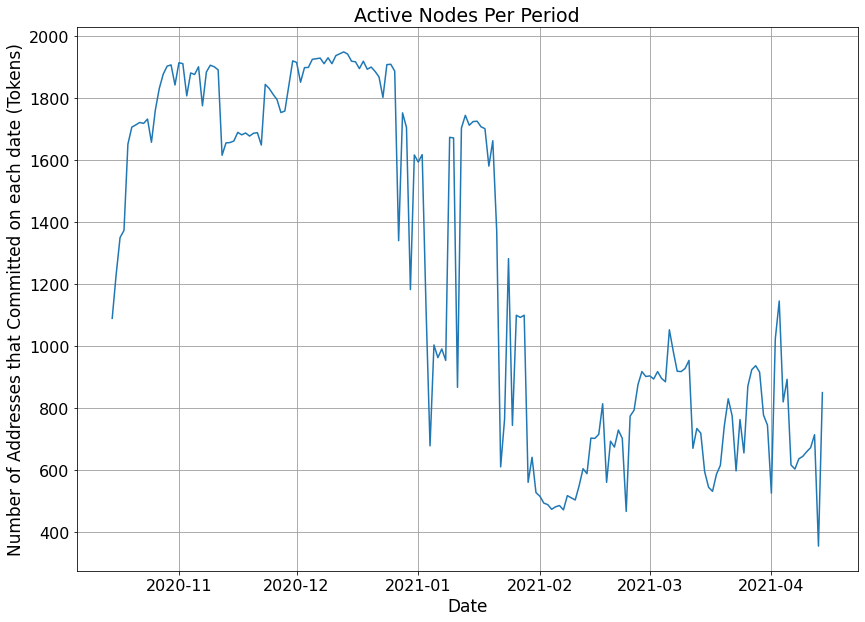

In [57]:
# First we plot the number of commitments (i.e. active workers) at each period 
ActiveWorkers_1day = df_1day.groupby('timestamp')['Staked'].count()
ActiveWorkers_1day = pd.DataFrame(ActiveWorkers_1day)
ActiveWorkers_1day.index = pd.to_datetime(ActiveWorkers_1day.index)

plt.plot(ActiveWorkers_1day)
plt.title('Active Nodes Per Period', fontsize=19)
plt.xlabel('Date', fontsize=17)
plt.ylabel('Number of Addresses that Committed on each date (Tokens)', fontsize=17)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
#plt.yscale('log')
plt.grid(b=True, which='major', color='#999999', linestyle='-')

In order to elucidate the factors which affect the number of independent nodes in the NuCypher network, we will examine the relationship between this time series (Active Nodes) and the _break-even stake size_ over the same 6 months. First, we derive an expression for this:


$$ Stake_{breakeven} = \frac{[(G_{commit} * G_{price} * ETH_{USD}) + C_{fixed}] * S_{committed}}{R_{total} * NU_{USD}} $$


Where the invariants and are:

- $G_{commit}$ 
Gas spent on period-to-period check-ins ~ 200,000 GWEI 

- $C_{fixed}$ 
Fixed costs of node operation, such as server costs ~ $3/day

- $R_{total}$
The total number of tokens distributed per period to all active stakers = 1,002,509.48 

The time-sensitive variables are:

- $G_{price}$
The average gas price on a given date

- $ETH_{USD}$ 
The ETH:USD exchange rate

- $NU_{USD}$
The NU:USD exchange rate

-  $S_{committed}$
The aggregate of all stakes whose corresponding workers commits in a given period. Note that this does not eqaul the total 'staked' in a given period, as a staker can have collateral locked but fail to commit to the next period, thereby forgoing the reward for that period. This aggregate value has a big impact on the _fraction_ of $R_{total}$ a stake will receieve. 

Note that $S_{committed}$ is not particularly easy to calculate using on-chain data – see note above about Locks and Withdrawals. 


Note that this expression assumes that the breakeven stake has a 12+ month lock duration, and therefore the kappa coefficient is at its maximum (=1). Any shorter lock duration would result in a smaller reward sum, and therefore a larger breakeven stake size. 

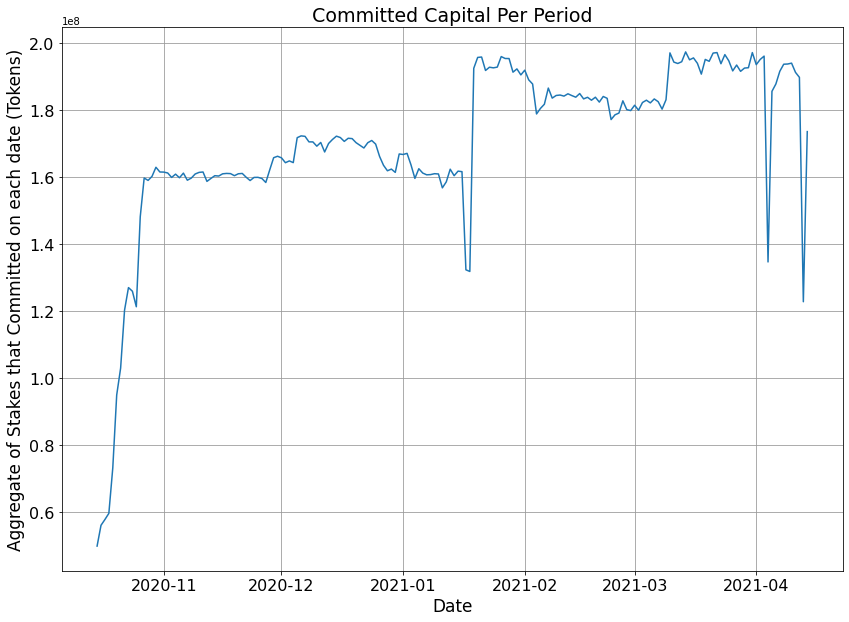

In [90]:
# Now we can compare the Active Node Count to the change in committed capital (i.e. the aggregation of all staked tokens associated with all commitments each period). 
CommmitedCapital_1day = df_1day.groupby('timestamp')['Staked'].sum()
CommmitedCapital_1day = pd.DataFrame(CommmitedCapital_1day)
CommmitedCapital_1day.index = pd.to_datetime(CommmitedCapital_1day.index)
#ComCap_1day.to_csv('CommittedCapital')
plt.plot(CommmitedCapital_1day)
plt.title('Committed Capital Per Period', fontsize=19)
plt.xlabel('Date', fontsize=17)
plt.ylabel('Aggregate of Stakes that Committed on each date (Tokens)', fontsize=17)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
#plt.yscale('log')
plt.grid(b=True, which='major', color='#999999', linestyle='-')

In [88]:
df_gp = pd.read_csv(r'gas_prices.csv')
#df_gp = pd.DataFrame(df_gp)


In [89]:
print (CommmitedCapital_1day.join(df_gp.set_index('timestamp'), on='timestamp').dropna())

ValueError: You are trying to merge on datetime64[ns] and object columns. If you wish to proceed you should use pd.concat

In [84]:
df = pd.concat([df_gp.set_index('timestamp'), CommmitedCapital_1day.set_index('timestamp')], axis=1, join='inner')


KeyError: "None of ['timestamp'] are in the columns"

In [72]:
df_gp = pd.read_csv(r'gas_prices.csv')
df_gp = df_gp.timestamp.astype('datetime64[ns]')
df_gp = pd.DataFrame(df_gp)
df_gp = pd.to_datetime(df_gp['timestamp'])
#df_gp = df_gp.set_index('timestamp', drop=True)
df_gp

0     2021-10-13
1     2021-10-12
2     2021-10-11
3     2021-10-10
4     2021-10-09
         ...    
373   2020-10-05
374   2020-10-04
375   2020-10-03
376   2020-10-02
377   2020-10-01
Name: timestamp, Length: 378, dtype: datetime64[ns]

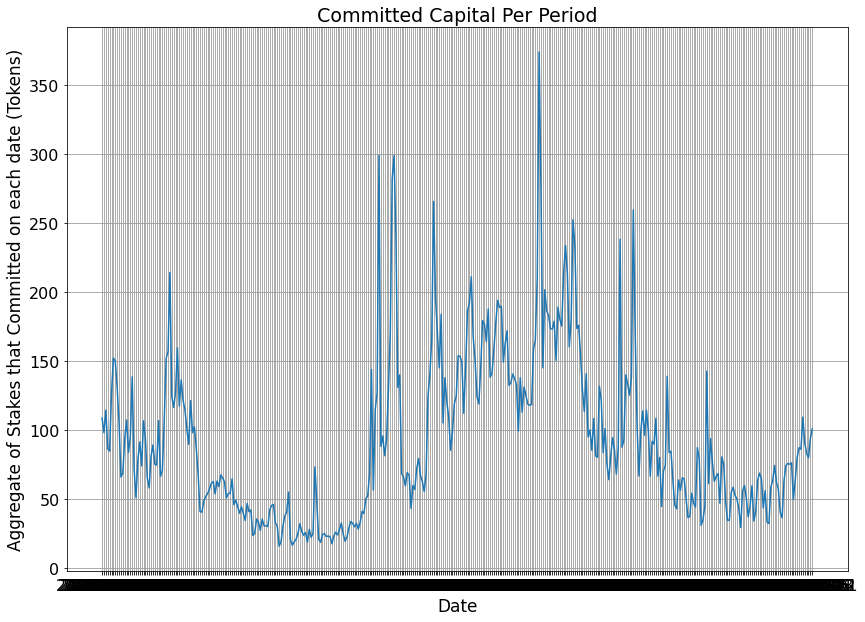